In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime
import pygmt

In [2]:
ls

currentEarthquakeArrivalInformation1CWithGains.csv  P_dataset_explore.ipynb
currentEarthquakeArrivalInformation3CWithGains.csv  p_example_model.ipynb
example_distributions.png                           P_feature_selection.ipynb
figures/                                            P_other_stations.ipynb
figures.ipynb                                       P_station_analysis/
gmap-stations.txt                                   s_example_model.ipynb
NGB_events_201309_201407.csv                        s_features.csv
NGB_usgs_search.csv                                 S_mags/
p_1c_features.csv


In [3]:
p_df = pd.read_csv('P_station_analysis/p_features.csv', dtype={'location_code': str})
s_df = pd.read_csv('s_features.csv', dtype={'location_code': str})

In [4]:
p_df["source_depth_km"].describe()

count    72952.000000
mean         7.190097
std          2.754650
min         -3.470000
25%          5.100000
50%          7.360000
75%          8.810000
max         23.480000
Name: source_depth_km, dtype: float64

In [5]:
p_evid_df = p_df.drop_duplicates("event_identifier")
s_evid_df = s_df.drop_duplicates("event_identifier")

In [6]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

/tmp/ipykernel_19753/1532912582.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")


In [7]:
print(np.all(np.isin(p_evid_df.event_identifier.unique(), all_eq_locs.event_identifier)))
print(np.all(np.isin(s_evid_df.event_identifier.unique(), all_eq_locs.event_identifier)))

True
True


In [8]:
# Reduce to events in the dataset 
p_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, p_evid_df.event_identifier.unique())]
s_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, s_evid_df.event_identifier.unique())]

# Make date column for filtering
p_locs_df.loc[:, "date"] = p_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))
s_locs_df.loc[:, "date"] = s_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_19753/2932727301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_locs_df.loc[:, "date"] = p_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))
/tmp/ipykernel_19753/2932727301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_locs_df.loc[:, "date"] = s_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [9]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_p_event_locs = p_locs_df.loc[
        (p_locs_df["date"] >= bounds["date_min"]) & (p_locs_df["date"] <= bounds["date_max"]) & 
        (p_locs_df["event_lat"] >= bounds["lat_min"]) & 
        (p_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * p_locs_df["event_lon"] >= bounds["lon_min"]) &
        (-1 * p_locs_df["event_lon"] <= bounds["lon_max"])]

ngb_s_event_locs = s_locs_df.loc[
        (s_locs_df["date"] >= bounds["date_min"]) & (s_locs_df["date"] <= bounds["date_max"]) & 
        (s_locs_df["event_lat"] >= bounds["lat_min"]) & 
        (s_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * s_locs_df["event_lon"] >= bounds["lon_min"]) & 
        (-1 * s_locs_df["event_lon"] <= bounds["lon_max"])]

In [10]:
p_ngb_removed = p_df[~np.isin(p_df.event_identifier, ngb_p_event_locs.event_identifier)]
p_ngb = p_df[np.isin(p_df.event_identifier, ngb_p_event_locs.event_identifier)]

s_ngb_removed = s_df[~np.isin(s_df.event_identifier, ngb_s_event_locs.event_identifier)]
s_ngb = s_df[np.isin(s_df.event_identifier, ngb_s_event_locs.event_identifier)]

In [11]:
print(len(p_ngb_removed["station"].unique()))
p_stat_counts = p_ngb_removed.value_counts("station").to_frame().reset_index()
p_stat_counts.columns = ["Station", "Count"]
p_stat_counts

60


,Station,Count
0,YNR,4505
1,YHH,4351
2,YMC,3992
3,YPM,3605
4,YMR,3571
5,YWB,3457
6,MCID,3399
7,YFT,3248
8,YHB,3133
9,YHL,3053


In [12]:
print(len(s_ngb_removed["station"].unique()))
s_stat_counts = s_ngb_removed.value_counts("station").to_frame().reset_index()
s_stat_counts.columns = ["Station", "Count"]
s_stat_counts

34


,Station,Count
0,YNR,2124
1,YMR,1429
2,YMC,1419
3,YFT,918
4,YHH,902
5,YHB,886
6,YUF,740
7,YHL,576
8,YML,504
9,YTP,476


In [13]:
# Keep stations with more than 350 observations
p_filtcounts = p_ngb_removed[np.isin(p_ngb_removed.station, p_stat_counts[p_stat_counts.Count >= 350])]

# Keep stations with more than 200 observations
s_filtcounts = s_ngb_removed[np.isin(s_ngb_removed.station, s_stat_counts[s_stat_counts.Count >= 200])]

In [14]:
print(len(p_stat_counts[p_stat_counts.Count >= 350]))
print(len(s_stat_counts[s_stat_counts.Count >= 200]))

34
16


In [15]:
p_filtcounts_evid = p_filtcounts.drop_duplicates("event_identifier")
s_filtcounts_evid = s_filtcounts.drop_duplicates("event_identifier")

In [16]:
p_filtcounts.magnitude_type.unique()

array(['l'], dtype=object)

In [17]:
s_filtcounts.magnitude_type.unique()

array(['l'], dtype=object)

In [18]:
p_filtcounts_evid["source_receiver_distance_km"].describe()

count    5732.000000
mean       11.049594
std         6.844895
min         0.106585
25%         6.775050
50%        10.067649
75%        13.067855
max        89.144323
Name: source_receiver_distance_km, dtype: float64

In [19]:
s_filtcounts_evid["source_receiver_distance_km"].describe()

count    4943.000000
mean       13.128412
std         9.040708
min         0.044877
25%         6.632662
50%        10.695324
75%        17.242386
max        83.316436
Name: source_receiver_distance_km, dtype: float64

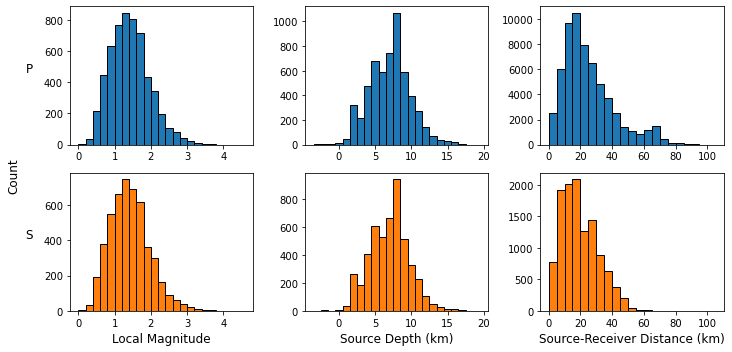

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
mag_bins = np.arange(0, 4.7, 0.2)
axes[0][0].hist(p_filtcounts_evid["magnitude"], edgecolor="k", bins=mag_bins)
axes[1][0].hist(s_filtcounts_evid["magnitude"], edgecolor="k", color="C1", bins=mag_bins)
axes[1][0].set_xlabel("Local Magnitude", fontsize=12)

depth_bins = np.arange(-3.5, 20, 1)
axes[0][1].hist(p_filtcounts_evid["source_depth_km"], edgecolor="k", bins=depth_bins)
axes[1][1].hist(s_filtcounts_evid["source_depth_km"], edgecolor="k", color="C1", bins=depth_bins)
axes[1][1].set_xlabel("Source Depth (km)", fontsize=12)

sr_bins = np.arange(0, 110, 5)
axes[0][2].hist(p_filtcounts["source_receiver_distance_km"], edgecolor="k", bins=sr_bins);
axes[1][2].hist(s_filtcounts["source_receiver_distance_km"], edgecolor="k", color="C1", bins=sr_bins)
axes[1][2].set_xlabel("Source-Receiver Distance (km)", fontsize=12)

axes[0][0].set_ylabel("P", fontsize=12, rotation=0, labelpad=15)
axes[1][0].set_ylabel("S", fontsize=12, rotation=0, labelpad=15)

fig.tight_layout()
fig.supylabel("Count", x=-0.01, fontsize=12)
fig.savefig("example_distributions.png", dpi=300, bbox_inches='tight')

In [21]:
# Read in station information
stat_df = pd.read_csv("gmap-stations.txt", sep='|', skiprows=[1, 2], skipinitialspace=True)
# Only keep stations that are in the dataset
stat_df = stat_df[np.isin(stat_df.Station, p_ngb_removed.station.unique())]
stat_df.head()

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
68,GS,ID08,42.896000,-111.838890,2054.0,"Devils Gate, Idaho, USA",2017-09-09T00:00:00,2017-10-25T20:14:00
77,IE,ECRI,43.054001,-111.371002,2086.0,"Eagle Creek, Idaho, USA",2002-01-01T00:00:00,2599-12-31T23:59:59
78,IE,GRRI,42.938000,-111.421997,2207.0,"Grays Lake, Idaho, USA",2002-01-01T00:00:00,2599-12-31T23:59:59
79,IE,HHAI,43.294998,-112.379501,1391.0,"Hells Half Acre, Idaho, USA",2002-01-01T00:00:00,2599-12-31T23:59:59
102,IW,FLWY,44.083002,-110.699888,2078.0,"Flagg Ranch, Wyoming, USA",2005-08-17T00:00:00,2599-12-31T23:59:59


In [22]:
# Check if any station information is missing 
print(len(p_stat_counts), len(stat_df.Station.unique()))
p_ngb_removed.station.unique()[~np.isin(p_ngb_removed.station.unique(), stat_df.Station)]

60 60


array([], dtype=object)

In [23]:
s_ngb_removed.station.unique()[~np.isin(s_ngb_removed.station.unique(), stat_df.Station)]

array([], dtype=object)

In [24]:
# Keep most recent station information
stat_df_unique = stat_df.sort_values(["Station", "EndTime"]).drop_duplicates("Station", keep='last')
p_stat_df_unique = stat_df_unique.merge(p_stat_counts)
s_stat_df_unique = stat_df_unique.merge(s_stat_counts)

In [25]:
# Read in park and caldera boundaries
utahnet_path = "../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera

,Longitude,Latitude
0,-110.6149,44.7057
1,-110.6154,44.7040
2,-110.6158,44.7023
3,-110.6162,44.7003
4,-110.6158,44.6986
...,...,...
881,-110.6137,44.7119
882,-110.6145,44.7102
883,-110.6153,44.7082
884,-110.6161,44.7068


In [26]:
s_ngb_filtcounts_evid = s_ngb[np.isin(s_ngb.station, s_stat_counts[s_stat_counts.Count >= 200])].drop_duplicates("event_identifier")
p_ngb_filtcounts_evid =  p_ngb[np.isin(p_ngb.station, p_stat_counts[p_stat_counts.Count >= 350])].drop_duplicates("event_identifier")

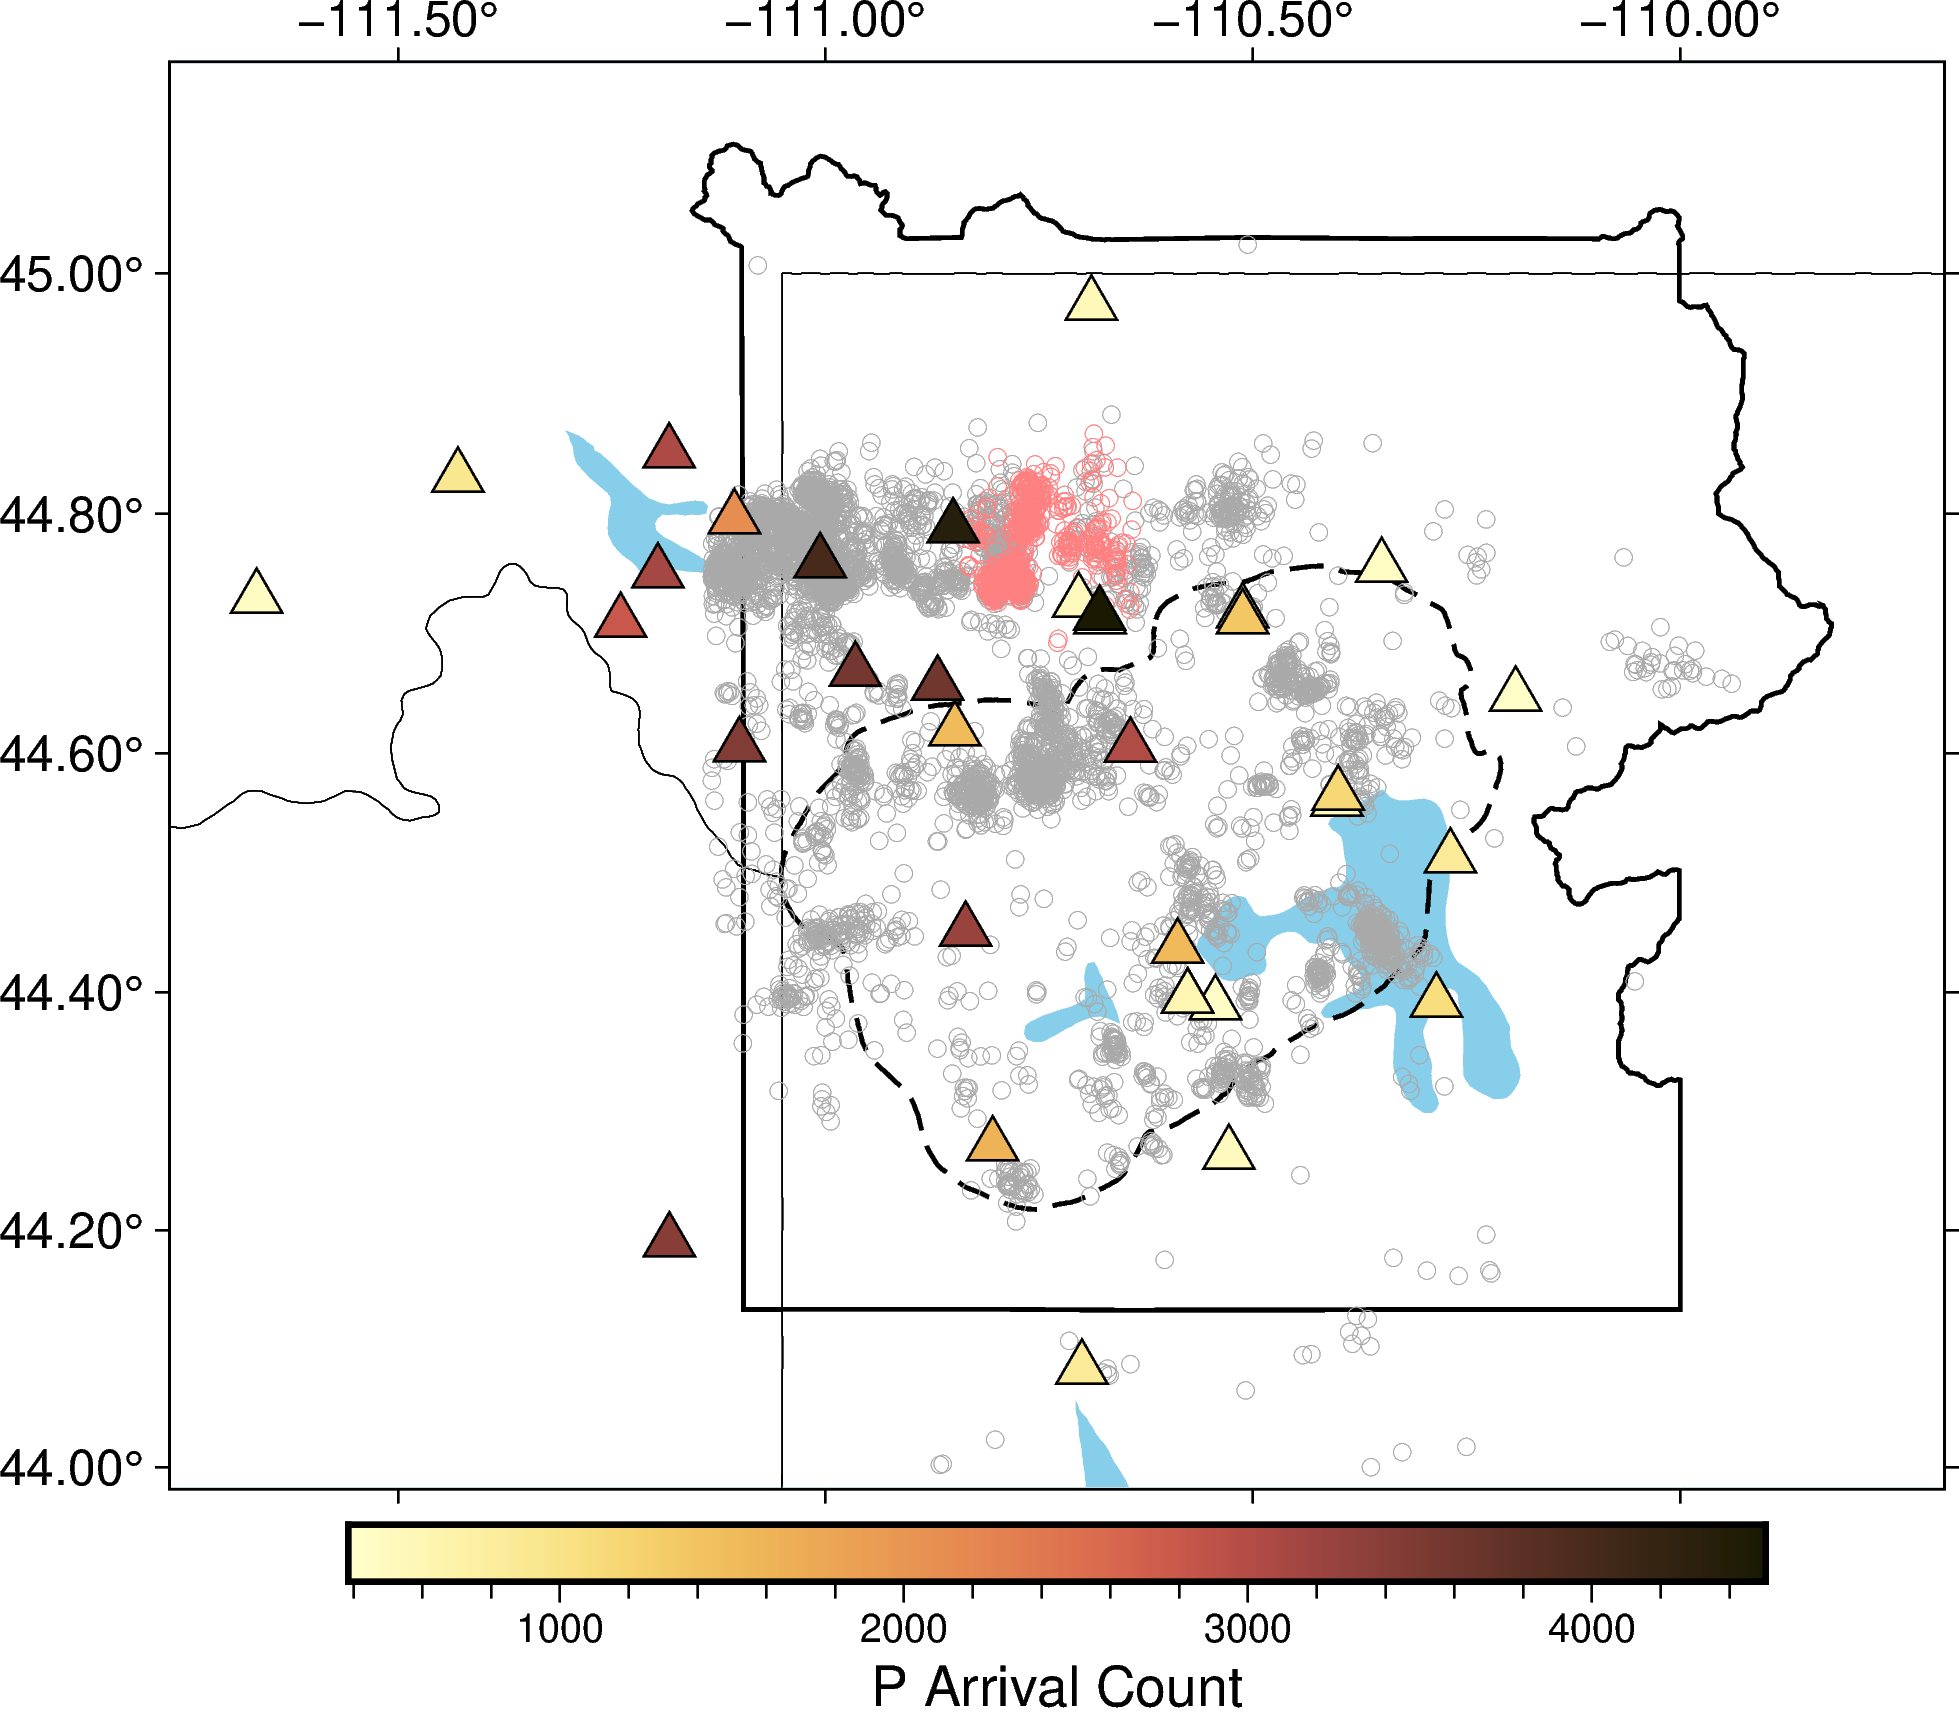

In [27]:
#Draw station map 
p_stats_used = p_stat_df_unique[p_stat_df_unique.Count >= 350]

region = [
    p_stats_used.Longitude.min() - 0.1,
    p_stats_used.Longitude.max() + 0.5,
    p_stats_used.Latitude.min() - 0.1,
    p_stats_used.Latitude.max() + 0.2,
]

fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xx")
with pygmt.config(MAP_FRAME_TYPE="plain", FONT='12p', FONT_ANNOT_PRIMARY='12p'):
    fig.basemap(region=region, projection="M15c", frame=["seNW+t", "xa0.5", "ya0.2"])
fig.coast(land="white", borders=2, water="skyblue")
pygmt.makecpt(cmap="lajolla", series=[p_stats_used.Count.min(), p_stats_used.Count.max()])
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black,--')

fig.plot(data=p_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
fig.plot(data=p_ngb_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

fig.plot(x=p_stats_used.Longitude, y=p_stats_used.Latitude,
         style="t0.5c", color=p_stats_used.Count, cmap=True, pen="0.5p,black")

fig.colorbar(frame='af+l"P Arrival Count"')
fig.show()

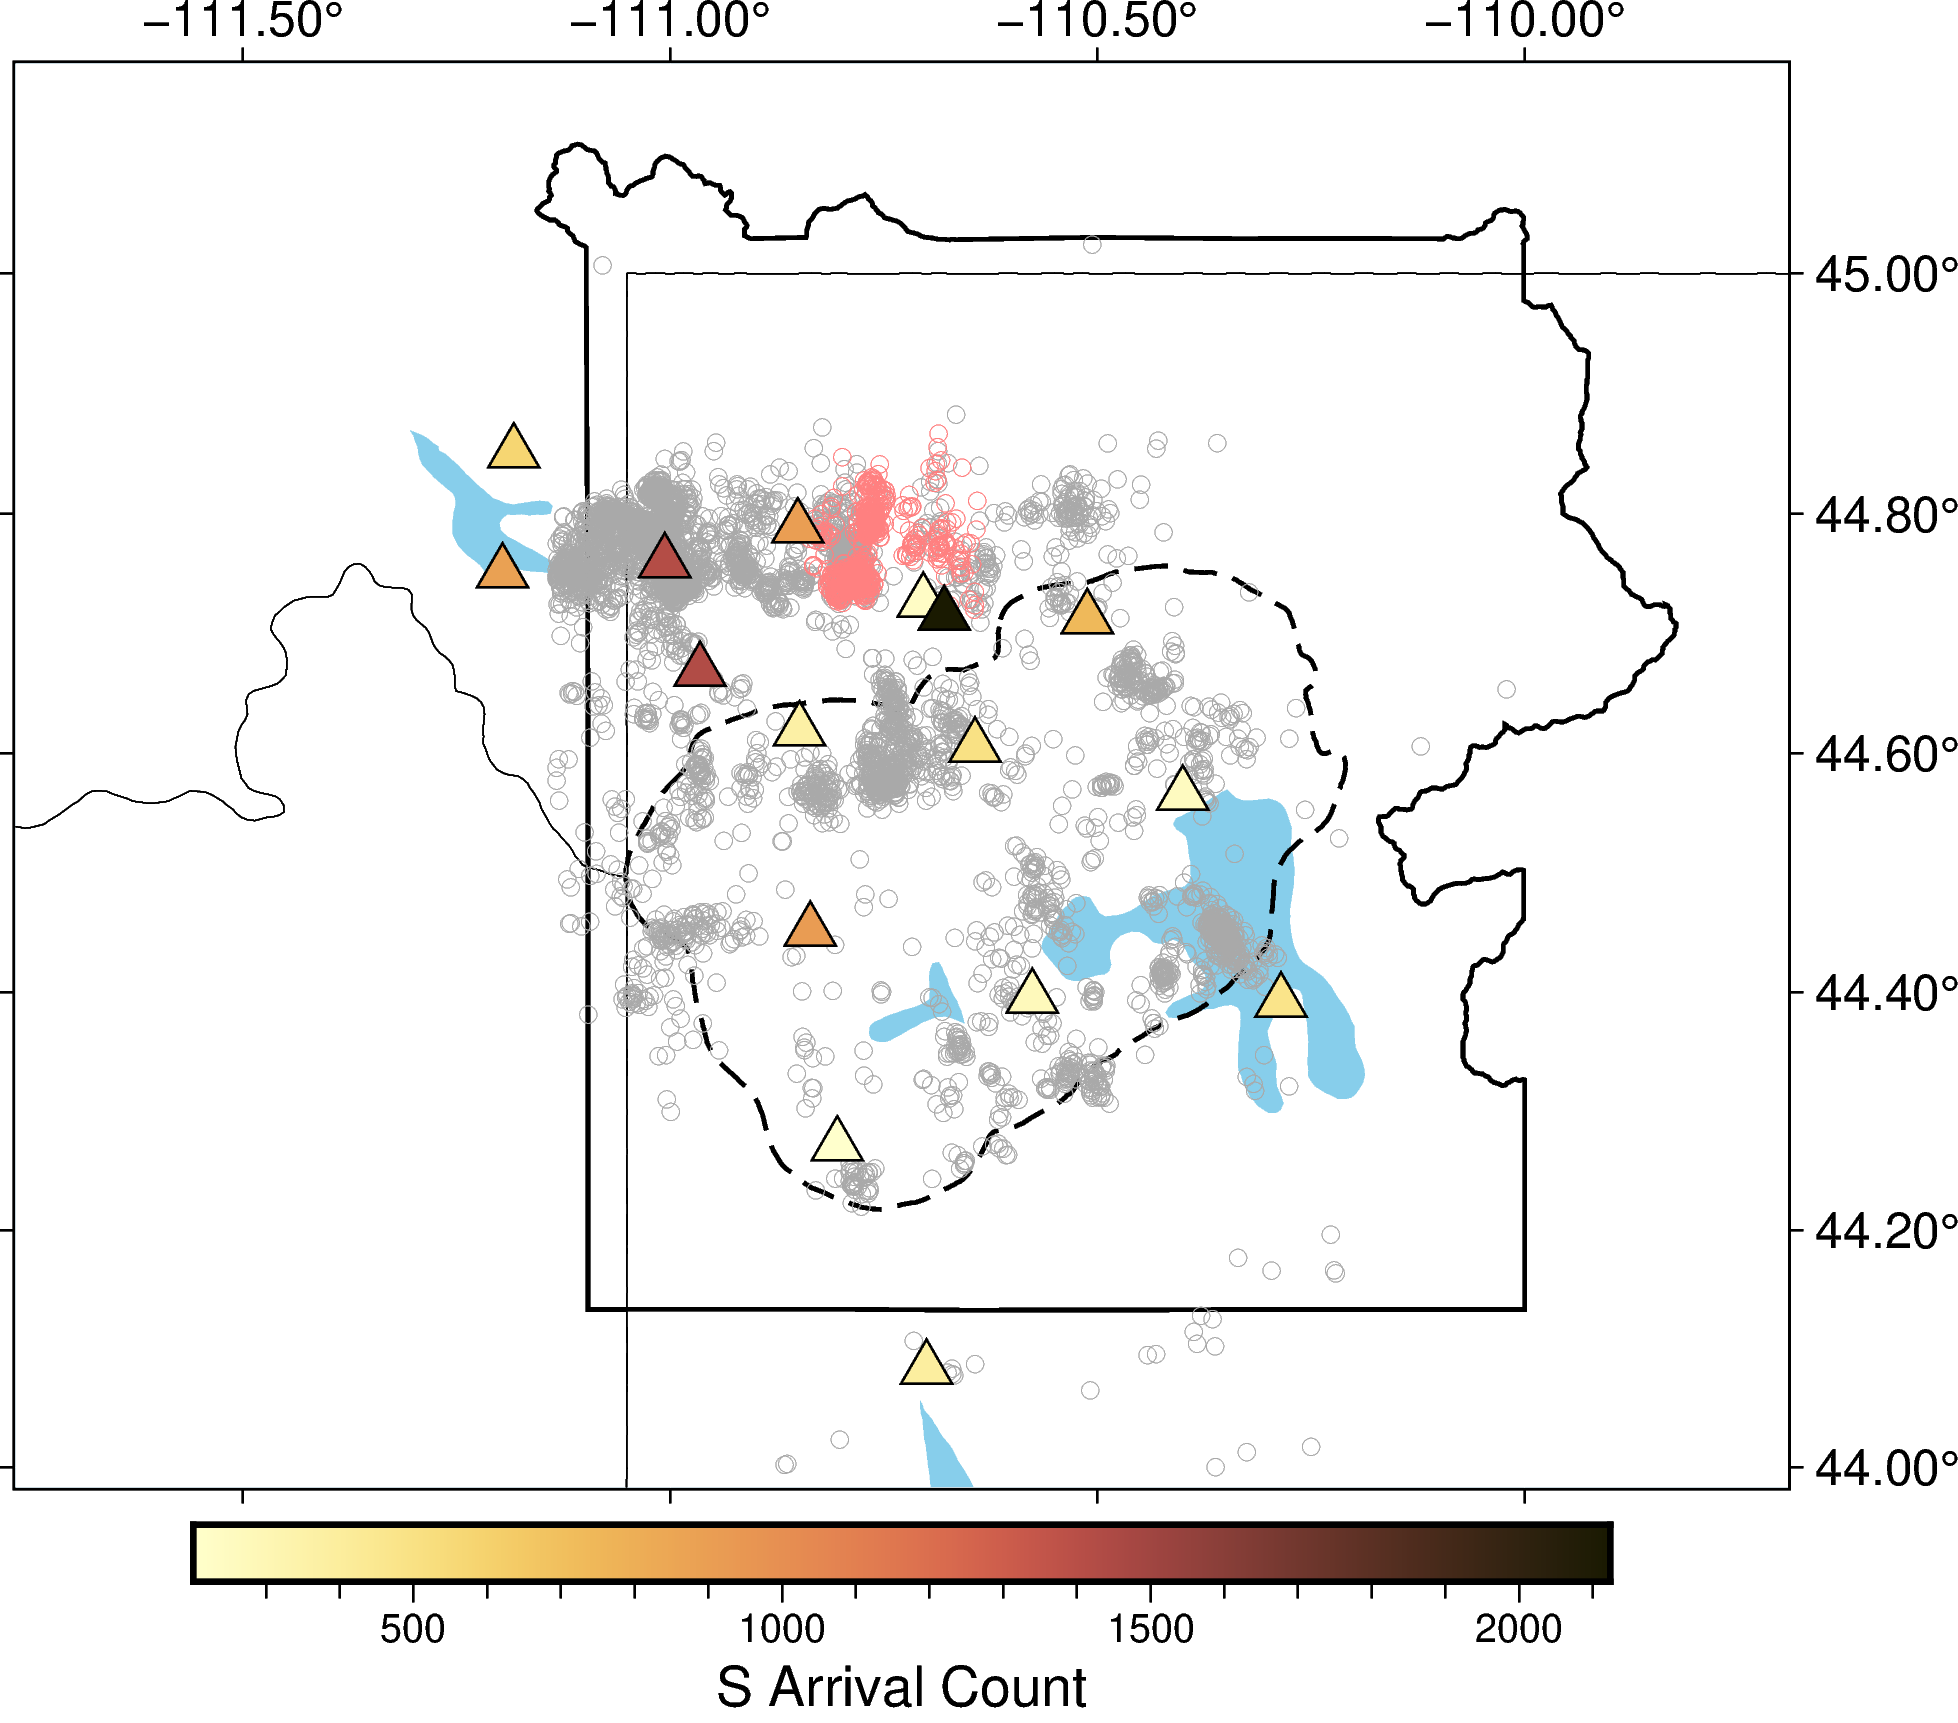

In [29]:
#Draw station map 
s_stats_used = s_stat_df_unique[s_stat_df_unique.Count >= 200]

# region = [
#     s_stats_used.Longitude.min() - 0.2,
#     p_stats_used.Longitude.max() + 0.5,
#     p_stats_used.Latitude.min() - 0.1,
#     p_stats_used.Latitude.max() + 0.2,
# ]

fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xx")
with pygmt.config(MAP_FRAME_TYPE="plain", FONT='12p', FONT_ANNOT_PRIMARY='12p'):
    fig.basemap(region=region, projection="M15c", frame=["sENw+t", "xa0.5", "ya0.2"])
fig.coast(land="white", borders=2, water="skyblue")

pygmt.makecpt(cmap="lajolla", series=[s_stats_used.Count.min(), s_stats_used.Count.max()])
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black,--')

fig.plot(data=s_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
fig.plot(data=s_ngb_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

fig.plot(x=s_stats_used.Longitude, y=s_stats_used.Latitude,
         style="t0.5c", color=s_stats_used.Count, cmap=True, pen="0.5p,black")

fig.colorbar(frame='af+l"S Arrival Count"')
fig.show()

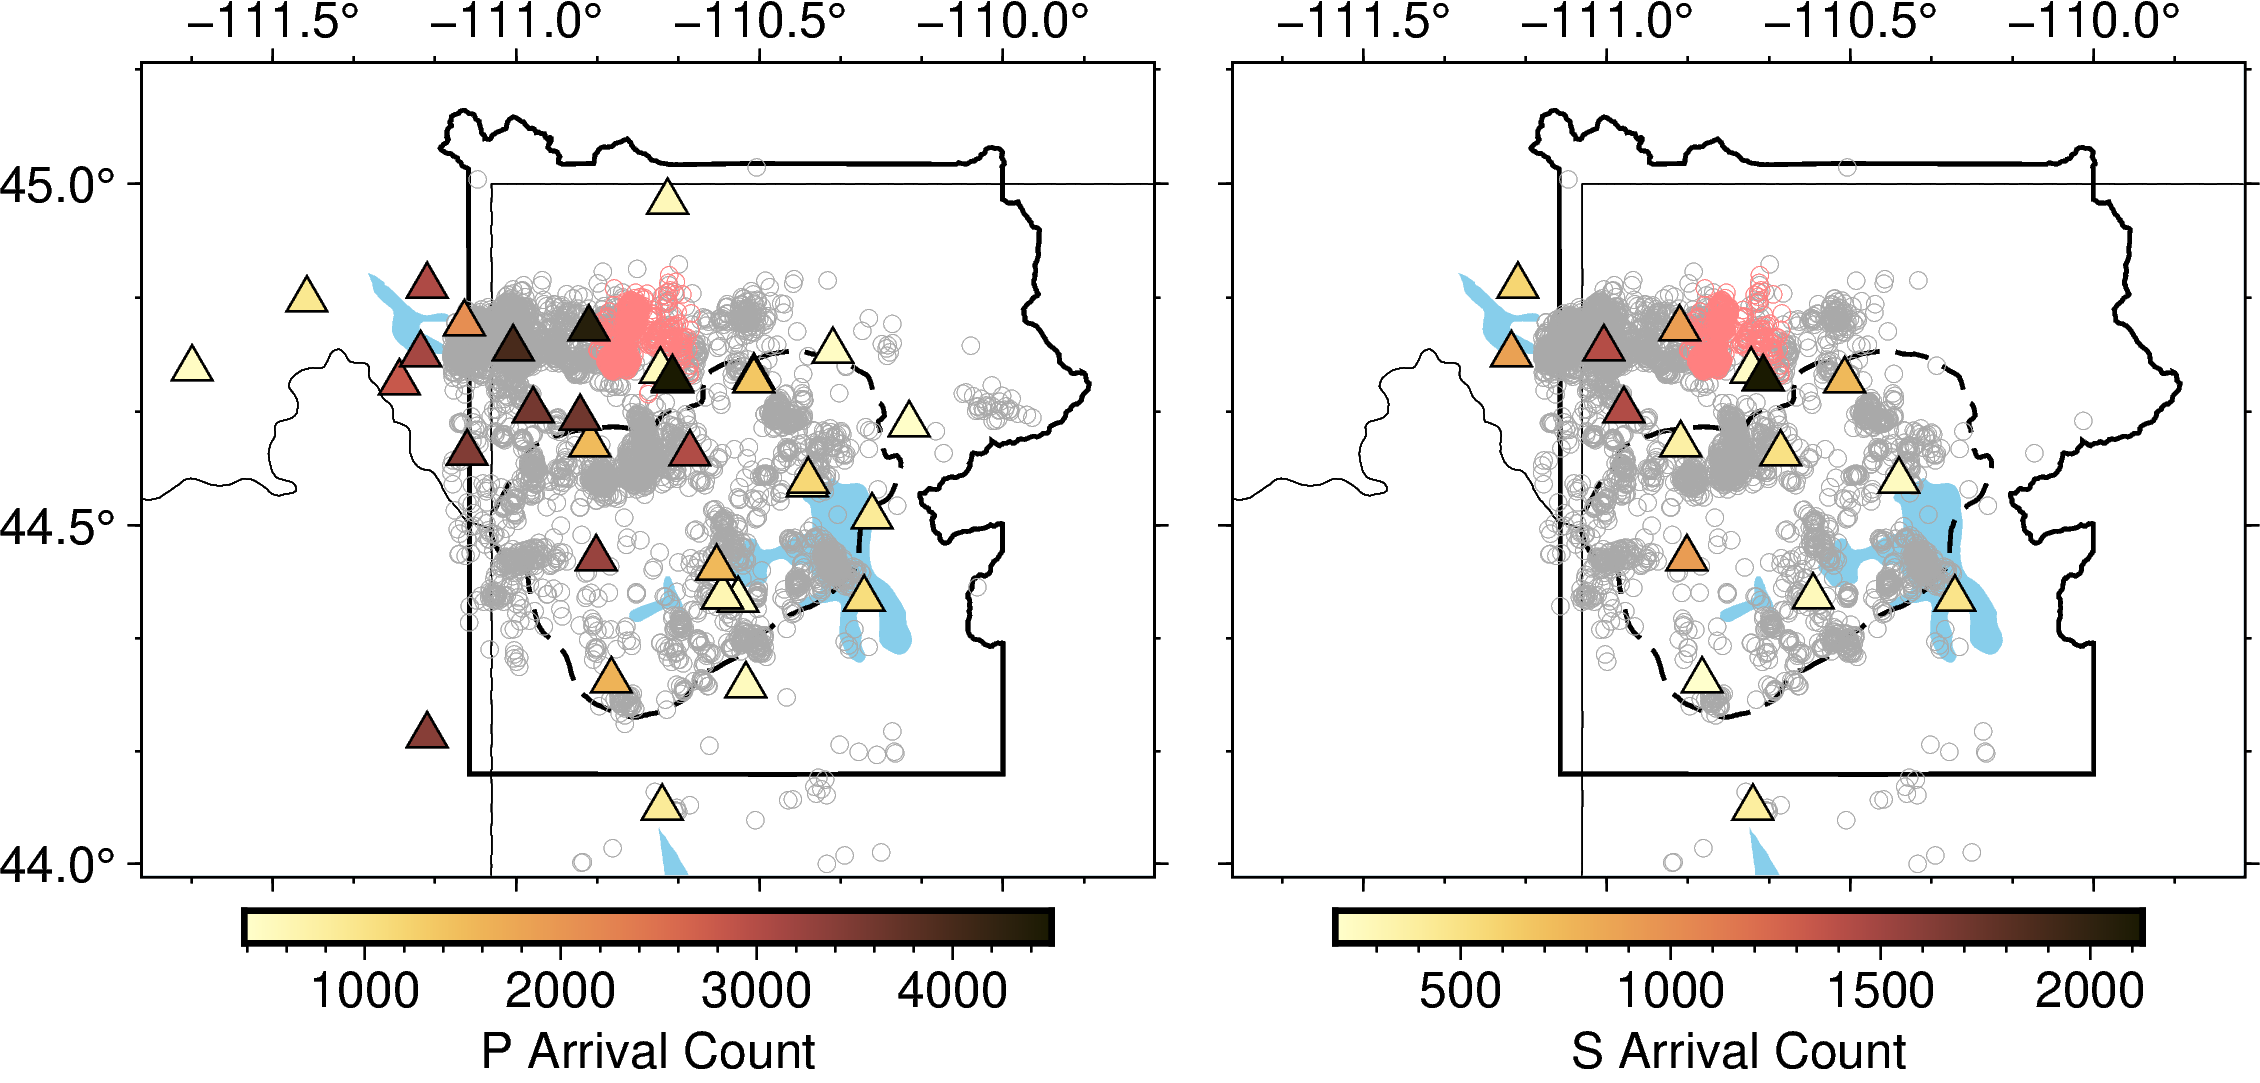

In [44]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT='12p', FONT_ANNOT_PRIMARY='12p')

with fig.subplot(ncols=2, figsize=("7i", "4i"), sharey='l', sharex='t'):
    with fig.set_panel(panel=0):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")
        pygmt.makecpt(cmap="lajolla", series=[p_stats_used.Count.min(), p_stats_used.Count.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        fig.plot(data=p_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=p_ngb_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=p_stats_used.Longitude, y=p_stats_used.Latitude,
        style="t0.4c", color=p_stats_used.Count, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"P Arrival Count"')
    with fig.set_panel(panel=1):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")

        pygmt.makecpt(cmap="lajolla", series=[s_stats_used.Count.min(), s_stats_used.Count.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        fig.plot(data=s_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=s_ngb_filtcounts_evid[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=s_stats_used.Longitude, y=s_stats_used.Latitude,
                 style="t0.4c", color=s_stats_used.Count, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"S Arrival Count"')
fig.show()
fig.savefig('side_by_side_station_counts.png', dpi=300)

In [45]:
len(s_filtcounts_evid)

4943

In [46]:
len(p_filtcounts_evid)

5732

In [47]:
p_locs_df.date.min()

121007

In [48]:
s_locs_df.date.min()

121007

In [49]:
p_locs_df.describe()

,event_identifier,event_lat,event_lon,origin_time,date
count,6.415000e+03,6415.000000,6415.000000,6.415000e+03,6415.000000
mean,6.021193e+07,44.674934,-110.820421,1.489061e+09,167503.034606
std,1.433813e+05,0.146851,0.224885,8.618564e+07,27242.977596
min,6.000062e+07,44.000167,-111.132833,1.349570e+09,121007.000000
25%,6.006916e+07,44.583333,-111.012500,1.400448e+09,140518.500000
50%,6.020915e+07,44.744000,-110.823167,1.498658e+09,170628.000000
75%,6.032313e+07,44.782000,-110.712250,1.556655e+09,190430.000000
max,6.047577e+07,45.023667,-109.939500,1.640981e+09,211231.000000
